In [23]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap

from tqdm import tqdm
import os
from kan import KAN, KANLayer
from kan.spline import *
from kan.utils import sparse_mask
import random
import torch.nn as nn
import os
from kan.Symbolic_KANLayer import Symbolic_KANLayer
from tqdm import tqdm
from kan.LBFGS import LBFGS
from scipy.special import gamma


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


-----
-----
## $f_1(x_1, x_2)$
$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


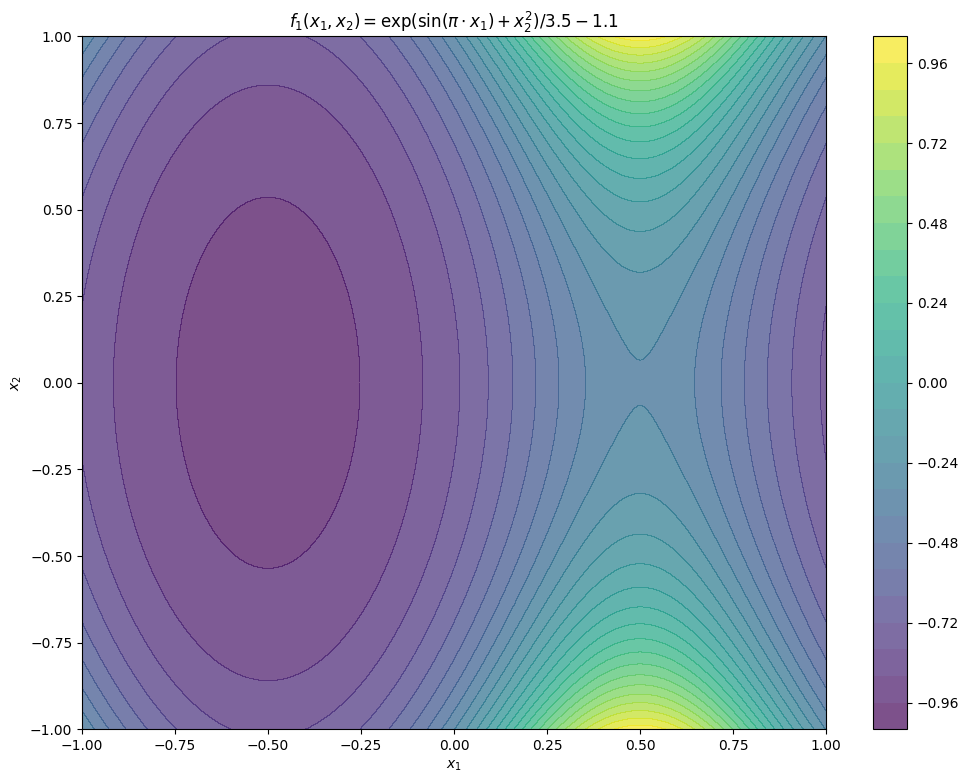

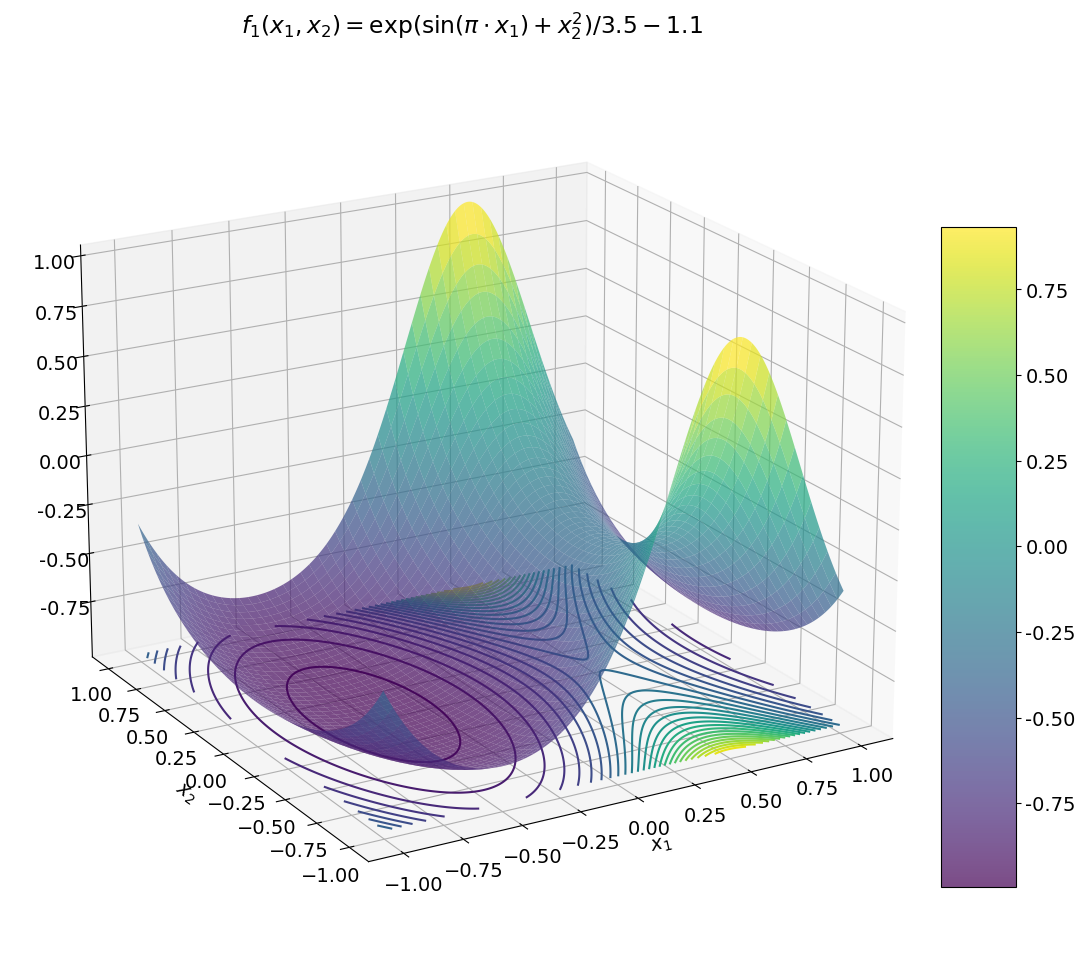

In [4]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2) / 3.5 - 1.1
dataset1 = create_dataset(f1, n_var=2, device=device)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

In [5]:
dataset['test_input'].shape

torch.Size([1000, 2])

## Demo of inter-channel entropy evaluating with gradients evaluating providng.

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 5.80e-02 | test_loss: 6.05e-02 | reg: 1.66e+01 | : 100%|█| 150/150 [01:08<00:00,  2.19


saving model version 0.1


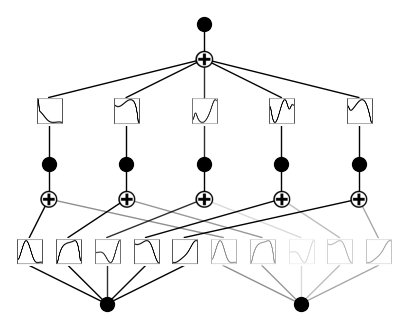

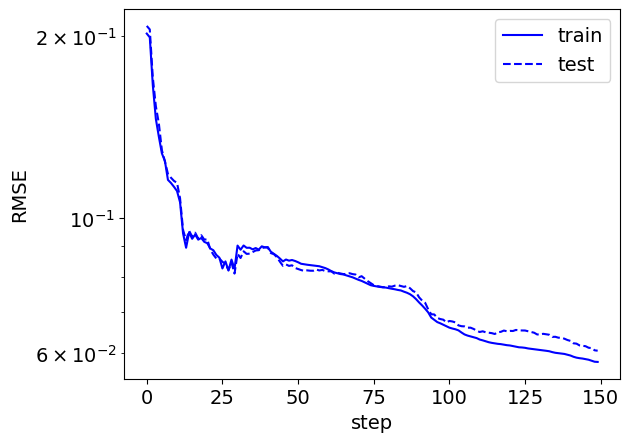

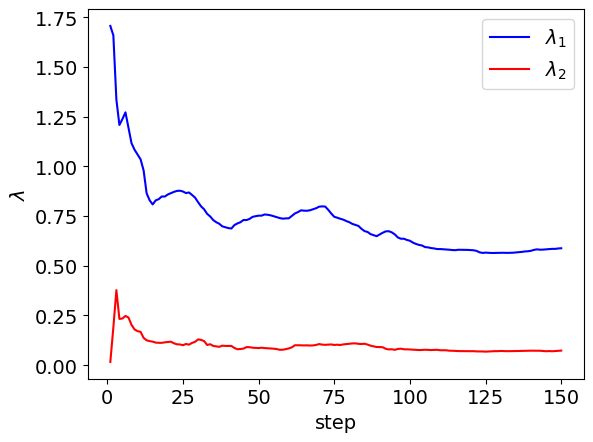

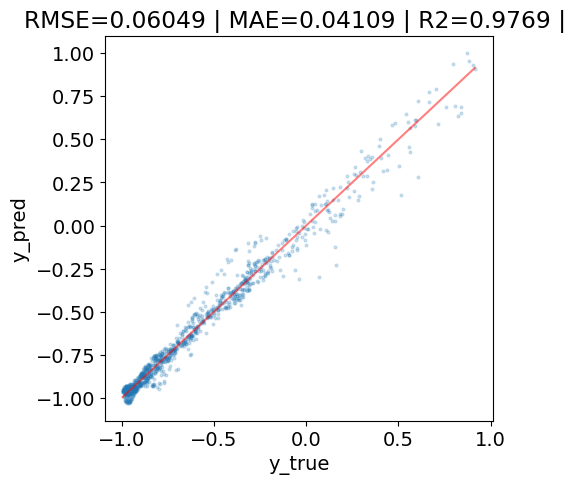

model.act_fun[0].lmd=Parameter containing:
tensor([0.5881, 0.0731], requires_grad=True)


In [6]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device, 
               lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, update_grid=True, grid_update_num=20)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

In [7]:
fin_layer = False

lmd_layer_acts_disp_scale = 1
out_layer_acts_disp_scale = 1

# Prepare lmd_layer_acts, out_layer_acts in shape (in_dim, out_dim, N) and (out_dim, N)
if fin_layer:
    lmd_layer_acts, out_layer_acts = model.beforelmd.detach().clone(), model.acts[-1].detach().clone()
else:
    lmd_layer_acts, out_layer_acts = model.beforelmd.detach().clone(), model.spline_postacts[1].detach().clone().squeeze()

lmd_layer_acts = lmd_layer_acts.permute(2, 1, 0) #(in_dim, out_dim, N)
out_layer_acts = out_layer_acts.permute(1, 0) #(out_dim, N)

_in_dim, _out_dim, _N = lmd_layer_acts.shape

lmd_layer_acts.shape, out_layer_acts.shape

(torch.Size([2, 5, 1000]), torch.Size([5, 1000]))

In [8]:
model.acts[-1].shape

torch.Size([1000, 1])

In [9]:
# Prepare std for norming
std_lmd_layer_acts = torch.std(lmd_layer_acts.detach().clone(), dim=-1) * lmd_layer_acts_disp_scale #(in_dim, out_dim)
std_out_layer_acts = torch.std(out_layer_acts.detach().clone(), dim=-1) * out_layer_acts_disp_scale #(out_dim)

std_lmd_layer_acts = std_lmd_layer_acts[:,:, None, None, None] #(in_dim, out_dim, 1, 1, 1)
std_out_layer_acts = std_out_layer_acts[None,:, None, None, None].expand(_in_dim, _out_dim, 1, 1, 1) #(in_dim, out_dim, 1, 1, 1)

std_data_vector = torch.cat((std_lmd_layer_acts, std_out_layer_acts), dim=-1) #(in_dim, out_dim, 1, 1, 2)

std_lmd_layer_acts.shape, std_out_layer_acts.shape, std_data_vector.shape

(torch.Size([2, 5, 1, 1, 1]),
 torch.Size([2, 5, 1, 1, 1]),
 torch.Size([2, 5, 1, 1, 2]))

In [10]:
# Prepare full_data as multiple pairs of (x, y) independently for each function
out_layer_acts = out_layer_acts.expand(1, _in_dim, _out_dim, _N) #(1, in_dim, out_dim, N)
lmd_layer_acts = torch.unsqueeze(lmd_layer_acts, 0) #(1, in_dim, out_dim, N)

out_layer_acts.shape, lmd_layer_acts.shape

(torch.Size([1, 2, 5, 1000]), torch.Size([1, 2, 5, 1000]))

In [11]:
full_data = torch.cat((lmd_layer_acts, out_layer_acts), dim=0) #(2, in_dim, out_dim, N)
full_data = full_data.permute(1, 2, 3, 0) #(in_dim, out_dim, N, 2)
full_data.shape

torch.Size([2, 5, 1000, 2])

In [12]:
# Prepare residuals as matrix of distances independently for x, y and each function
full_data = full_data.unsqueeze(dim=2) #(in_dim, out_dim, 1, N, 2)
residuals = full_data - full_data.detach().clone().swapaxes(-2, -3) #(in_dim, out_dim, N', N, 2); N' - is not differentiable, stands for points in which kernel dencity is estimated

# Norming residuals on std and calculate distances**2
squared_distances = torch.sum(torch.square(residuals / std_data_vector), dim=-1) #(in_dim, out_dim, N', N)
squared_distances.shape

torch.Size([2, 5, 1000, 1000])

In [13]:
from scipy.special import gamma


def radial_function(squared_distances, beta=1, trash_hold_std=None):
    
    if trash_hold_std!=None:
        _squared_distances = squared_distances.detach().clone()
        _trash_hold_mask = _squared_distances * (1 - torch.heaviside(_squared_distances, torch.Tensor([trash_hold_std])))
        
        squared_distances = squared_distances * _trash_hold_mask #(in_dim, out_dim, N', N)
    
    if beta==1:
        c = 1/(2*torch.pi) #norming for each probability (before summing)
        kernel_values = c * torch.exp(-squared_distances / 2) #(in_dim, out_dim, N', N)
        
    else:
        c = beta/(torch.pi * gamma(1/beta) * 2**(1/beta))
        kernel_values = c * torch.exp(-torch.pow(squared_distances, beta) / 2) #(in_dim, out_dim, N', N)
    
    return kernel_values

In [14]:
# Applying radial_function to squared_distances
kernel_values = radial_function(squared_distances, beta=1, trash_hold_std=3)
kernal_probs = kernel_values.sum(dim=-1)

kernel_values.shape

torch.Size([2, 5, 1000, 1000])

In [15]:
# Create _zero_diag_mask to exclude diagonal probs in kernal_probs
_zero_diag_mask = (torch.ones(_N, _N) - torch.eye(_N, _N)) #(N', N)
_zero_diag_mask.shape

torch.Size([1000, 1000])

In [16]:
# Finally, create and norm kernal_probs
kernal_probs = (_zero_diag_mask * kernel_values).sum(dim=-1) #(in_dim, out_dim, N')

kernal_probs = kernal_probs / torch.sum(kernal_probs.detach().clone(), dim=-1, keepdim=True) #(in_dim, out_dim, N')
kernal_probs.shape

torch.Size([2, 5, 1000])

In [17]:
# Evaluate negative Entropy from kernal_probs
n_entropy = torch.sum(torch.log(kernal_probs), dim=-1) * 1/_N #(in_dim, out_dim)
n_entropy.shape

torch.Size([2, 5])

In [18]:
# Average negative Entropy and uae it as regression summand
averaged_n_entropy = torch.mean(n_entropy)
averaged_n_entropy

tensor(-6.9078)

## Demo of $R^2$ and entropy regression.

In [26]:
def fit_regr_demo(
    self, dataset, opt="LBFGS", steps=100, log=1, lamb=1., lamb_l1=0., lamb_entropy=0., lamb_coef=0., lamb_coefdiff=0., lamb_lmd_interm=1.0, lamb_lmd_final=0.0, lmd_layer_acts_disp_scale=1, out_layer_acts_disp_scale=1, trash_hold_std=None, reg_type='entropy', 
    show_corr_plot_freq=10, interm_layer_corr_plot=True, final_layer_corr_plot=False,
    update_grid=True, grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
    metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training
    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar
    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['test_loss'], 1D array of test losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
    Example
    -------
    >>> from kan import *
    >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.3, seed=2)
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2)
    >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
    >>> model.plot()
    # Most examples in toturals involve the fit() method. Please check them for useness.
    '''
    if lamb > 0. and not self.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set self.save_act=True')
        
    old_save_act, old_symbolic_enabled = self.disable_symbolic_in_fit(lamb)
    pbar = tqdm(range(steps), desc='description', ncols=100)
    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn
    grid_update_freq = int(stop_grid_update_step / grid_update_num)
    if opt == "Adam":
        optimizer = torch.optim.Adam(self.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(self.get_params(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    results = {}
    results['train_loss'] = []
    results['test_loss'] = []
    results['reg'] = []
    results['lmd'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []
    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_test = dataset['test_input'].shape[0]
    else:
        batch_size = batch
        batch_size_test = batch
    global train_loss, reg_
    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        #train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if self.save_act:
            if reg_metric == 'edge_backward':
                self.attribute()
            if reg_metric == 'node_backward':
                self.node_attribute()
            reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, lamb_lmd_interm, lamb_lmd_final, lmd_layer_acts_disp_scale, out_layer_acts_disp_scale, trash_hold_std)
        else:
            reg_ = torch.tensor(0.)
        objective = lamb * reg_#objective = train_loss + lamb * reg_
        train_loss = objective
        objective.backward()
        return objective
    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    for _ in pbar:
        
        if _ == steps-1 and old_save_act:
            self.save_act = True
            
        if save_fig and _ % save_fig_freq == 0:
            save_act = self.save_act
            self.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)
        if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid and _ >= start_grid_update_step:
            self.update_grid(dataset['train_input'][train_id])
        if opt == "LBFGS":
            optimizer.step(closure)
        if opt == "Adam":
            pred = self.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            #train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if self.save_act:
                if reg_metric == 'edge_backward':
                    self.attribute()
                if reg_metric == 'node_backward':
                    self.node_attribute()
                reg_ = self.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, lamb_lmd_interm, lamb_lmd_final, lmd_layer_acts_disp_scale, out_layer_acts_disp_scale, trash_hold_std, type=reg_type)
            else:
                reg_ = torch.tensor(0.)
            loss = lamb * reg_#train_loss + lamb * reg_
            train_loss = loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id]), dataset['test_label'][test_id])
        
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())
        results['lmd'].append(self.act_fun[0].lmd.cpu().detach().clone().numpy())#
        #print(f'{self.act_fun[0].lmd.cpu().detach().numpy()=}')
        if _ % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | test_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(test_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)
                
        if _ % show_corr_plot_freq == 0:
            if interm_layer_corr_plot:
                self.lmd_corr_plot(fin_layer=False, title_text=f'epoch={_} | Interm. layer')
            if final_layer_corr_plot:
                self.lmd_corr_plot(fin_layer=True, title_text=f'epoch={_} | Final layer')
                
        
        if save_fig and _ % save_fig_freq == 0:
            self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            self.save_act = save_act
    self.log_history('fit')
    # revert back to original state
    self.symbolic_enabled = old_symbolic_enabled
    return results


checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 142


| train_loss: nan | test_loss: 7.09e-01 | reg: -6.98e+00 | :   0%|          | 0/150 [00:01<?, ?it/s]

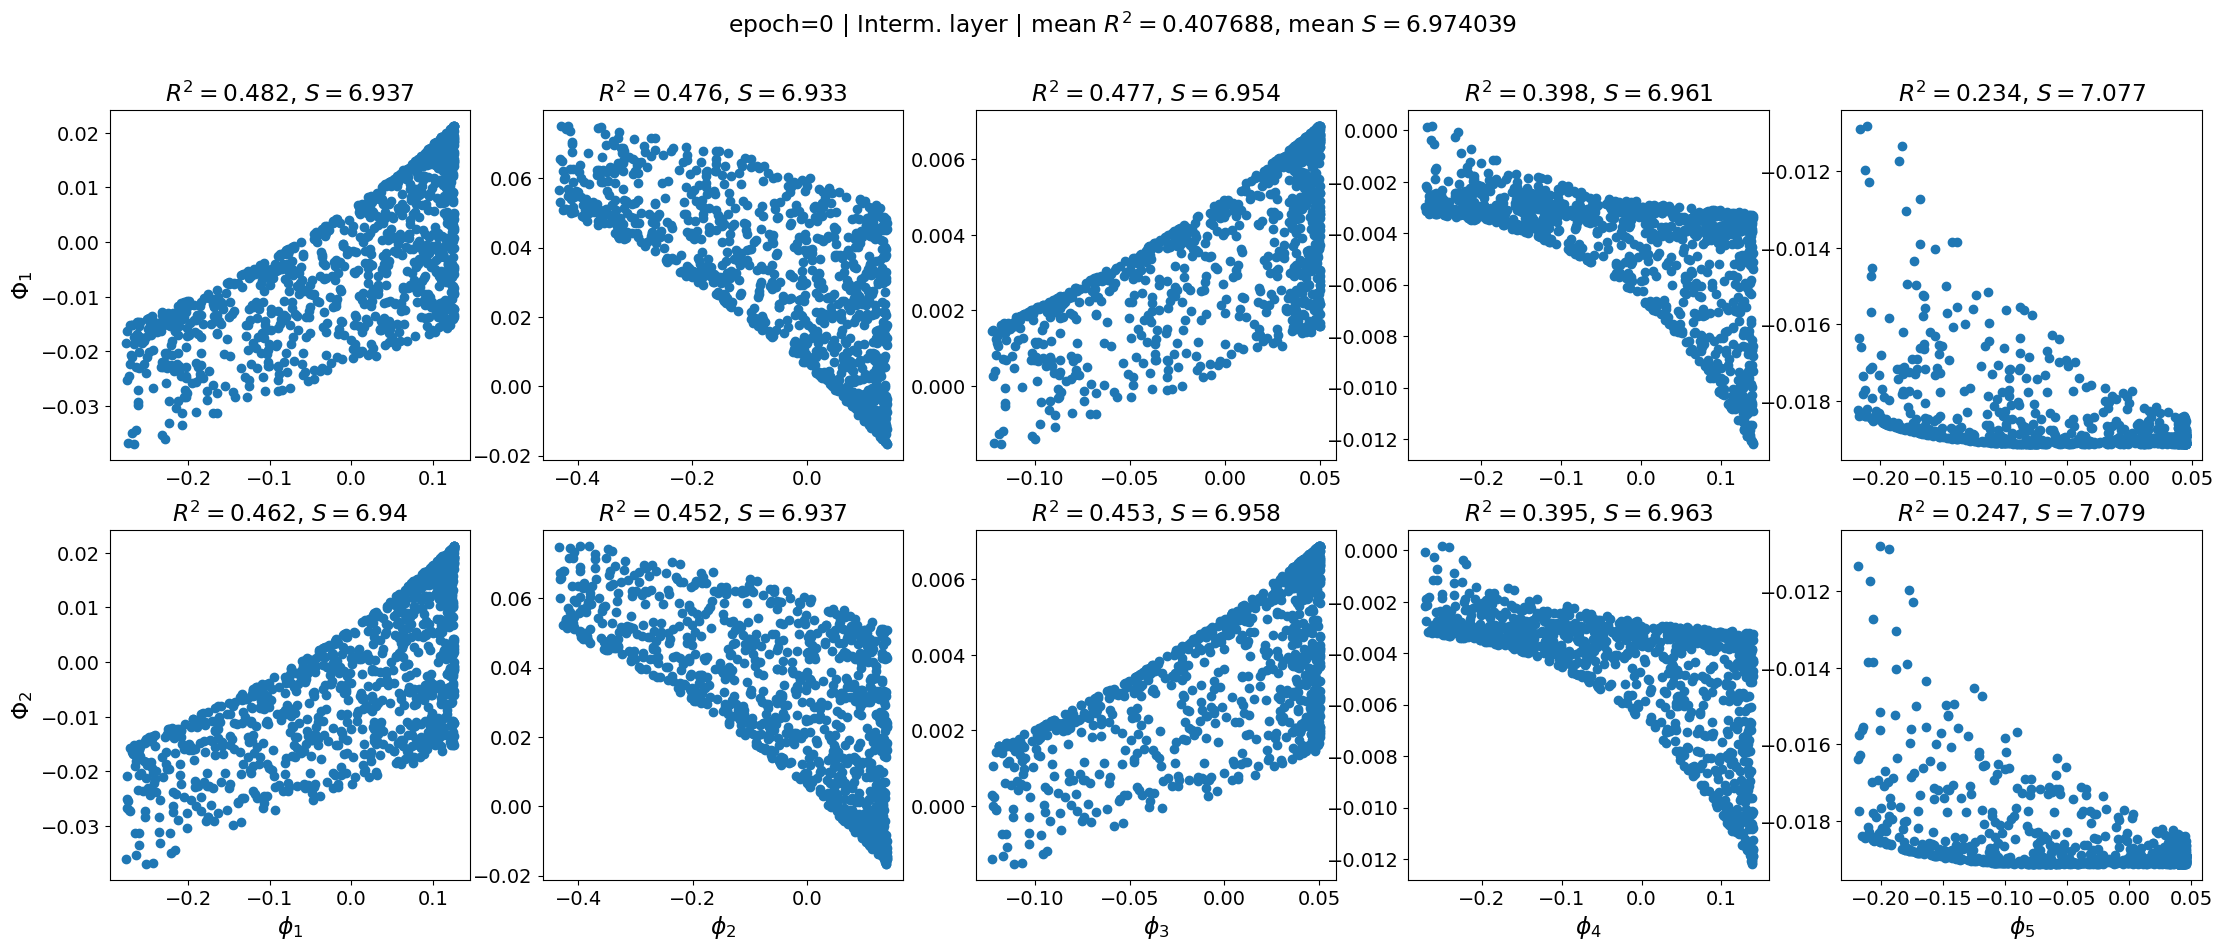

| train_loss: nan | test_loss: 7.09e-01 | reg: -6.98e+00 | :   7%| | 10/150 [00:26<05:39,  2.43s/it]

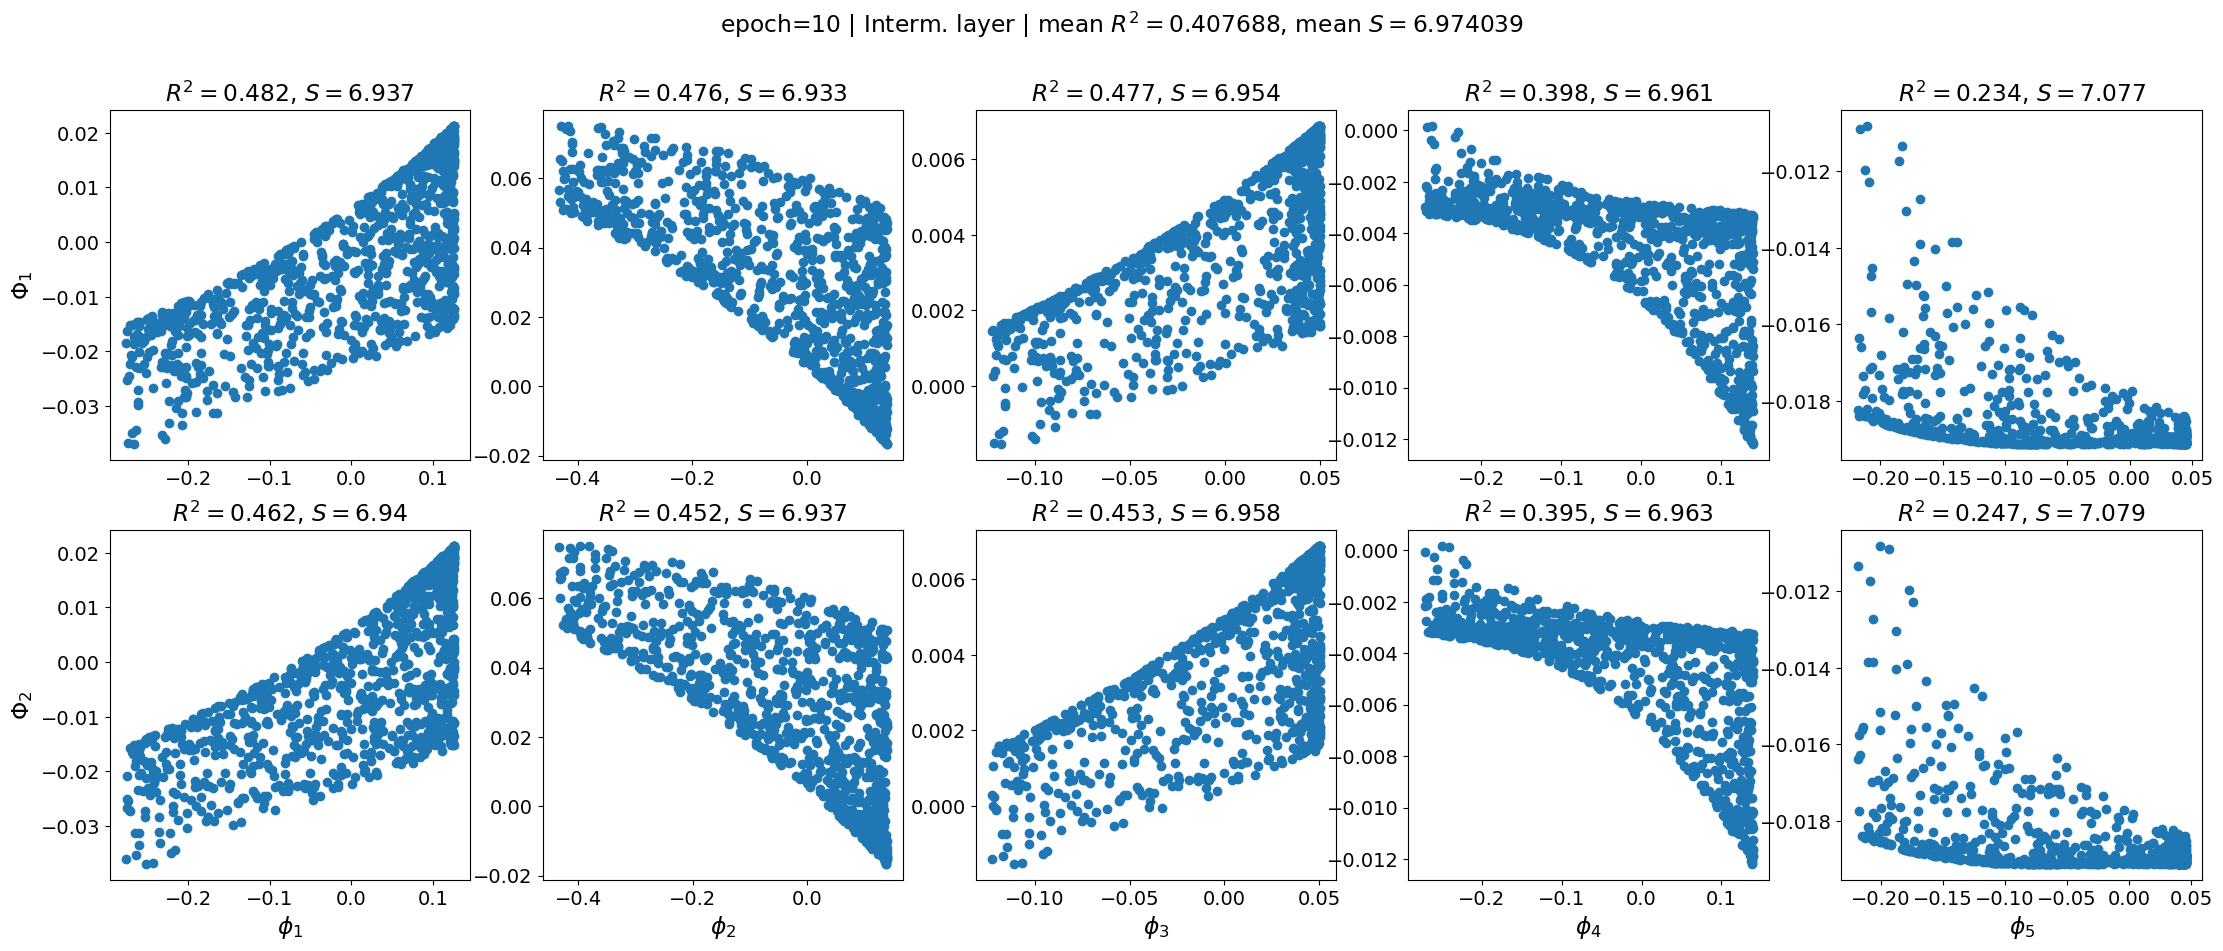

| train_loss: nan | test_loss: 7.09e-01 | reg: -6.98e+00 | :  13%|▏| 20/150 [00:52<05:21,  2.47s/it]

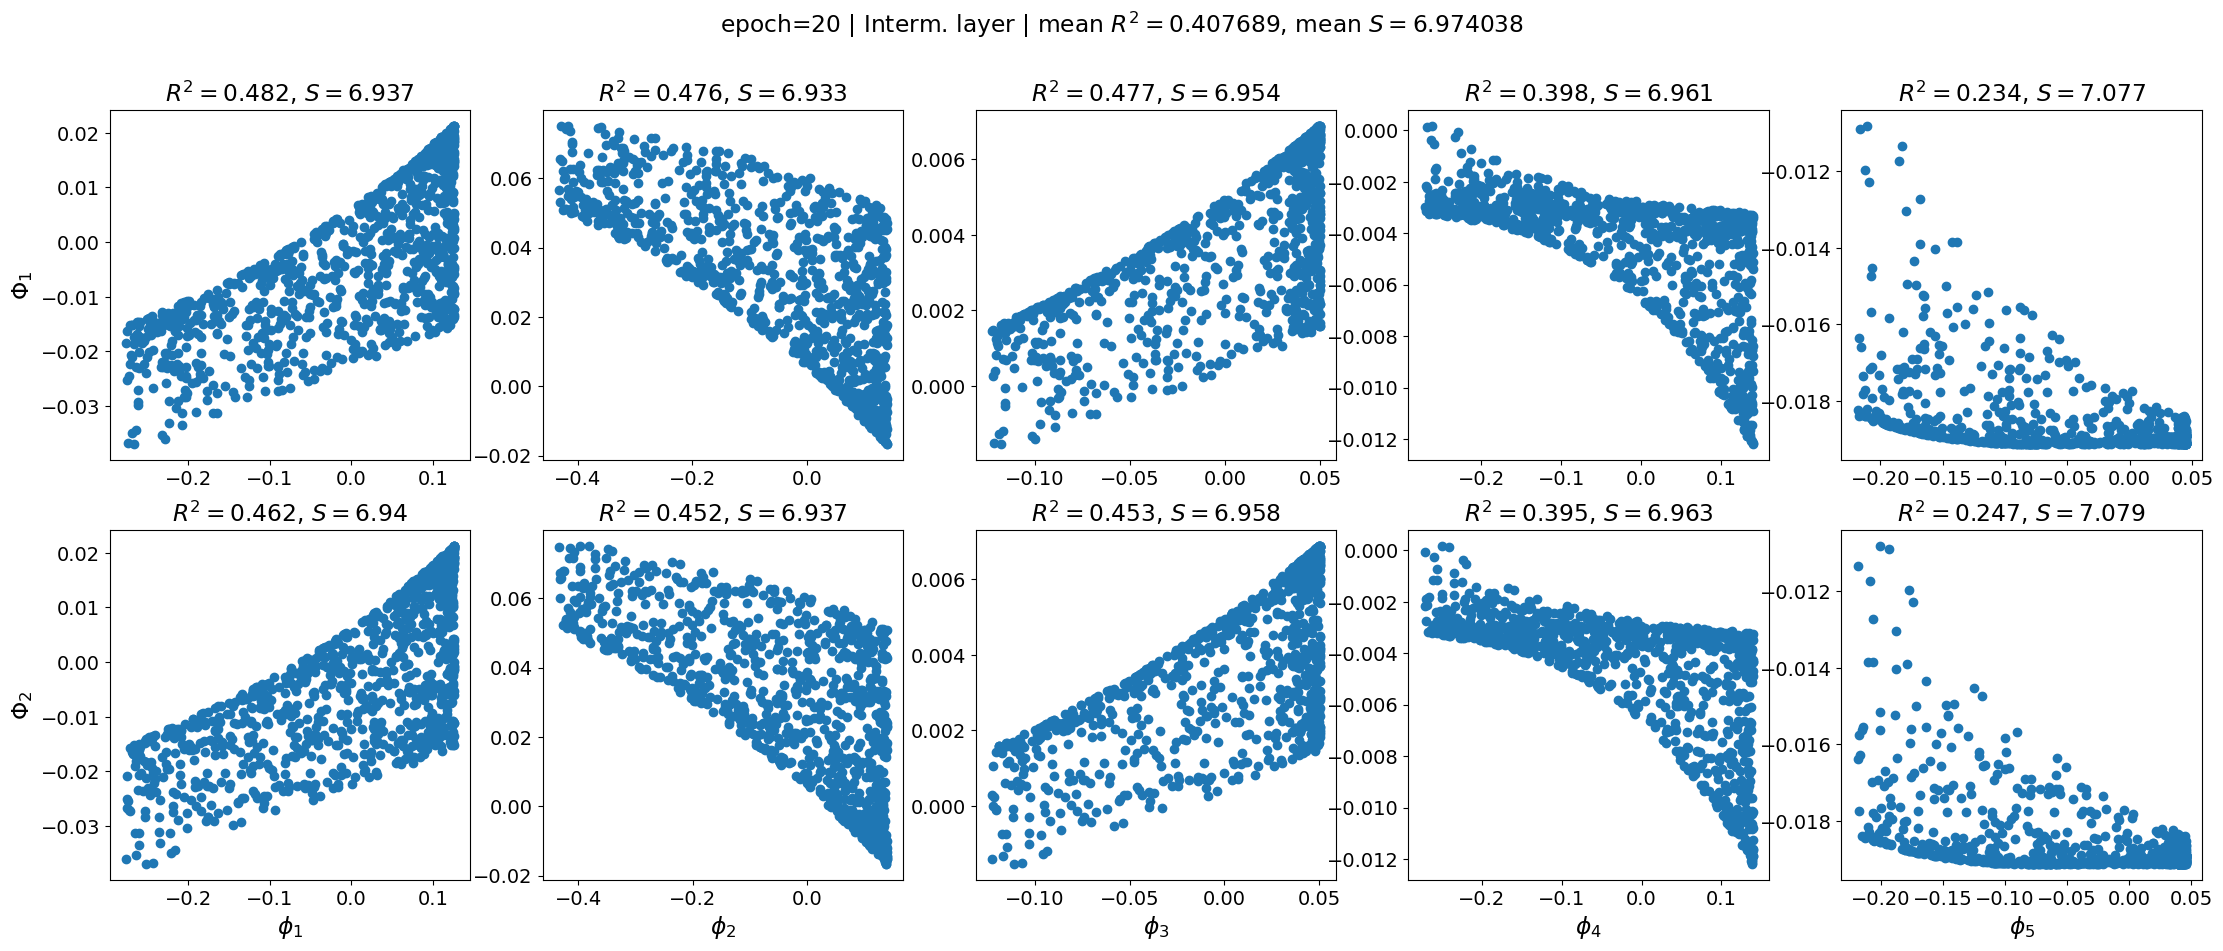

| train_loss: nan | test_loss: 7.09e-01 | reg: -6.98e+00 | :  15%|▏| 23/150 [00:59<05:31,  2.61s/it]


KeyboardInterrupt: 

In [28]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[2,5,1], grid=3, k=3, seed=1, device=device, 
               lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = fit_regr_demo(model, dataset, steps=150, update_grid=True, grid_update_num=20,
                        lamb=1., lamb_l1=0., lamb_entropy=0., lamb_coef=0., lamb_coefdiff=0., 
                        lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='entropy',
                        show_corr_plot_freq=10, interm_layer_corr_plot=True, final_layer_corr_plot=False,)
#kan_summary_after_fit(model, dataset, results, lmdKAN=True)
#print(f'{model.act_fun[0].lmd=}')